In [0]:
%matplotlib inline

In [0]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import datetime as dt
import pickle
import os

In [58]:
!pip install dgl

In [0]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F

In [0]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [0]:
class GCNLayer(nn.Module):
  def __init__(self, in_feats, out_feats):
    super(GCNLayer, self).__init__()
    self.linear = nn.Linear(in_feats, out_feats)

  def forward(self, g, feature):
    with g.local_scope():
      g.ndata['h'] = feature
      g.update_all(gcn_msg, gcn_reduce)
      h = g.ndata['h']
      return self.linear(h)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = GCNLayer(20, 15)
    self.layer2 = GCNLayer(15, 10)
    self.layer3 = GCNLayer(10, 2)

  def forward(self, g, features):
    x = F.relu(self.layer1(g, features))
    x = F.relu(self.layer2(g, x))
    x = F.sigmoid(self.layer3(g, x))
    return x

In [0]:
def load_data(file):
  with open(f'model_ready_data/{file}', 'rb') as f:
    C, features, targets = pickle.load(f)
  features = th.FloatTensor(features)
  targets = th.FloatTensor(targets)
  g = dgl.DGLGraph()
  g.from_networkx(C)
  return g, features, targets

In [0]:
def forecast(net, start_date='2020-05-01', end_date='2020-05-08'):
  g, features, targets = load_data(start_date+'.pkl')
  date = dt.datetime.strptime(start_date, '%Y-%m-%d')
  end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')
  while date < end_date:
    pred = net(g, features)
    features[:,0:9] = features[:,1:10]
    features[:9] = pred[:,0]
    features[:,10:19] = features[:,11:20]
    features[:,19] = pred[:,1]




In [129]:
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=20, out_features=15, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=15, out_features=10, bias=True)
  )
  (layer3): GCNLayer(
    (linear): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [0]:
train_files = []
test_files = []
for file in os.listdir('model_ready_data'):
  date = dt.datetime.strptime(file[:-4], '%Y-%m-%d')
  if date < dt.datetime.strptime('2020-05-01', '%Y-%m-%d'):
    train_files.append(file)
  else:
    test_files.append(file)

In [131]:
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)
n_epochs = 100
train_loss = []
test_loss = []
for epoch in range(n_epochs):
  train_loss_epoch = []
  test_loss_epoch = []
  for file in train_files:
    g, features, targets = load_data(file)
    
    net.train()
    pred = net(g, features)
    loss = F.mse_loss(pred, targets)
    train_loss_epoch.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  for file in test_files:
    g, features, targets = load_data(file)
    pred = net(g, features)
    loss = F.mse_loss(pred, targets)
    test_loss_epoch.append(loss.item())

  train_loss.append(np.mean(train_loss_epoch))
  test_loss.append(np.mean(test_loss_epoch))

  if epoch % 10 == 0:
    print(f'Epoch: {epoch}, Train Loss: {train_loss[epoch]}, Test Loss: {test_loss[epoch]}')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, Train Loss: 0.1546418274856276, Test Loss: 0.07480077585205436
Epoch: 10, Train Loss: 0.011405329185072333, Test Loss: 0.045326412189751863
Epoch: 20, Train Loss: 0.010735140483464217, Test Loss: 0.048446732107549906
Epoch: 30, Train Loss: 0.010211934614279826, Test Loss: 0.04518706118687987
Epoch: 40, Train Loss: 0.009845206419413444, Test Loss: 0.04418879561126232
Epoch: 50, Train Loss: 0.009575670843979525, Test Loss: 0.03923469386063516
Epoch: 60, Train Loss: 0.009353279179413221, Test Loss: 0.03995015821419656
Epoch: 70, Train Loss: 0.009315856711428852, Test Loss: 0.03836562926881015
Epoch: 80, Train Loss: 0.009054983227724734, Test Loss: 0.03989159339107573
Epoch: 90, Train Loss: 0.009128690308160811, Test Loss: 0.0390078853815794


In [0]:
g, features, targets = load_data('2020-05-08.pkl')

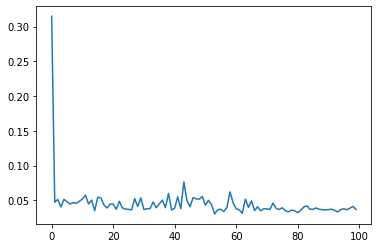

In [128]:
plt.plot(test_loss)

In [135]:
net(g, features)[:,0]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.6941, 0.8000, 0.8767, 0.7080, 0.7609, 0.9390, 0.7111, 0.7013, 0.7055,
        0.7298, 0.6627, 0.6357, 0.6986, 0.9148, 0.6782, 0.6761, 0.6837, 0.6516,
        0.7975, 0.6867, 0.8832, 0.7439, 0.7615, 0.8097, 0.7871, 0.7345, 0.7256,
        0.7268, 0.9159, 0.7143, 0.8024, 0.7713, 0.6987, 0.7401, 0.6740, 0.8778,
        0.6578, 0.6710, 0.8032, 0.8746, 0.8491, 0.7558, 0.6956, 0.8018, 0.8008,
        0.8262, 0.8229, 0.9277, 0.6423, 0.8532, 0.6204, 0.7529, 0.7883, 0.6793,
        0.7882, 0.8050, 0.7454, 0.8340, 0.7563, 0.6321, 0.8309, 0.8340],
       grad_fn=<SelectBackward>)

In [149]:
features[:,20]

IndexError: ignored